# DAND - Project 2 - Data Analysis

*This document and the accompanying files can be found on [GitHub](https://github.com/anenkov/dand-da-titanic)*

### This project will conduct a Data Analysis on the Titanic passengers' data

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import re

In [2]:
# Set seaborn plots
sns.set(style="whitegrid", context="paper")
sns.set_context(rc={"figure.figsize": (8, 4)})

# load the data
passengers_df = pd.read_csv("titanic_data.csv")
passengers_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S


We are interested in several questions:
* Average survival rate and distribution in ages
* The survival rate of children (age under 18), adult males, adult females
* Survival rate by socio-economic status (Pclass)
* Does having Sibling or Spouse on the ship inrease/decrease survivability (SibSp > 0 or Parch > 0)
* Are there any tendencies for Port of Embarkation - e.g. survivors or dead concentration

In [3]:
pd.DataFrame({"Rows" :passengers_df.count()}).T

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Rows,891,891,891,891,891,714,891,891,891,891,204,889


The data is somewhat clean. We'll not use 'Cabin' which is the most missing and will ignore it. For the missing 'Ages' and 'Embarked' will omit those rows when we use the data. Although about 20% of the data is missing age this should not cause great impact because sample size remains 714 which is more than enough for some conclusions. Should be noted that there are 25 people of the sample whose age is 'Estimated' but this should not affect the outcome significantly. 

In [4]:
survival_mean = passengers_df["Survived"].mean()
print "Survived {} out of {}".format(passengers_df["Survived"].sum(), passengers_df["Survived"].count())
print "Average probability of survival: {}".format(round(survival_mean, 2))

Survived 342 out of 891
Average probability of survival: 0.38


### Survivability by age

First will clean the data removing rows without age. Will create new Data Frame in case we need the original later on

In [5]:
# Clean the data by removing rows with missing data to ease further calculations
df_with_ages = passengers_df[pd.notnull(passengers_df['Age'])]

In [6]:
# Function used to visualize barplots for Survivability
def visualize_surv_barplot(df):
    ax = sns.barplot(data=df)
    ax.set_ylabel("Survivability")
    
def visualize_surv_violin(df):
    sns.violinplot(x='Survived', y='Age', data=df, cut=0)

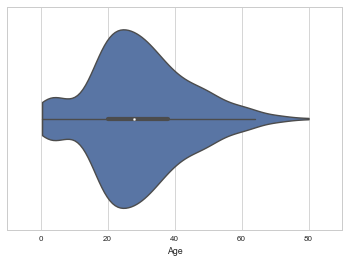

In [7]:
%matplotlib inline
# take all the passengers with 'Age' cleaning the NaN values
df_with_ages = passengers_df[pd.notnull(passengers_df['Age'])]

# visualize age disrtibution
sns.violinplot(x=df_with_ages['Age'], cut=0)

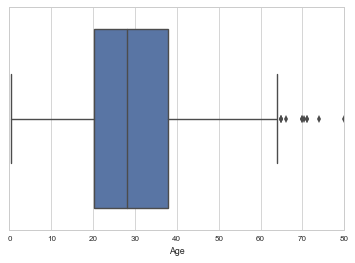

In [8]:
# visualize age distribution with boxplot
sns.boxplot(x=df_with_ages['Age'])

We can see the age distribution is positively skewed but not too much with some outliers in the upper end.

Now we'll separate people in bins of 10 years each to see the average survivability in groups

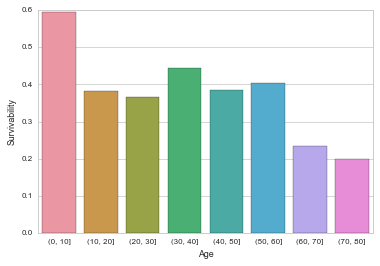

In [9]:
# group them by 10 years 
group_by_age = df_with_ages.groupby(
    pd.cut(df_with_ages['Age'], np.arange(0, 90, 10), include_lowest=False)
)

# Visualize age groups survivability
visualize_surv_barplot(pd.DataFrame(group_by_age['Survived'].mean()).T)

The distribution would be uniform if wasn't for the both ends which are above the mean for the children under 10 and below the mean for the older people above 60.

Another interesting aspect would be distribution of ages between those who survived and those who did not.

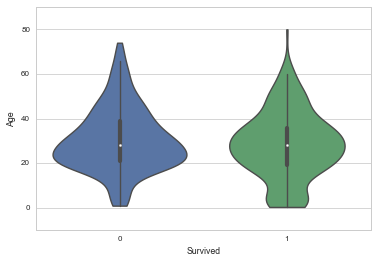

In [10]:
# visualize distribution by age
visualize_surv_violin(df_with_ages)

The distribution of survivors is more normalized than the one containing all people while the one with non-survivors is clearly positively skewed. It's really surprising that the death rate between prime age (20-30) people is so high but that's probably cause of the humanity factor to save children and elders first. It can be seen clearly that the children distribution is a lot higher in the surviving group.

### Survivability split by children, adult males and adult females

As a start we should create those groups in order to investigate them

In [11]:
def group_by_sex_adult(df, ind):
    if df['Age'].loc[ind] < 18:
        return 'Children'
    elif df['Sex'].loc[ind] == 'male':
        return 'Adult males'
    else:
        return 'Adult females'

sex_age_grp = df_with_ages.groupby(lambda x: group_by_sex_adult(df_with_ages, x))

Now some descriptive numbers

In [12]:
sex_age_grp[['Age','Survived']].mean()

,Age,Survived
Adult females,32.902913,0.771845
Adult males,33.937975,0.177215
Children,9.041327,0.539823


The difference between men and women is striking but probably expected. The children surivability is little low but this might be because of the lower class - something we'll check later.

In [13]:
def get_adults_by_gender(gender):
    return df_with_ages[(df_with_ages['Age'] >= 18) & (df_with_ages['Sex'] == gender)]

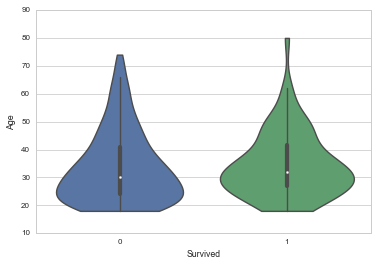

In [14]:
# Display men violin
visualize_surv_violin(get_adults_by_gender('male'))

For adult males the violins are almost identical. The mean of survivors is just a little more than the other.

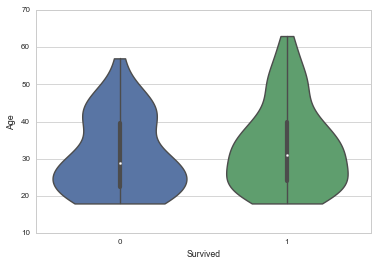

In [15]:
# Display women violin
visualize_surv_violin(get_adults_by_gender('female'))

Here, for women is almost the same with little more spread distribution for survivors

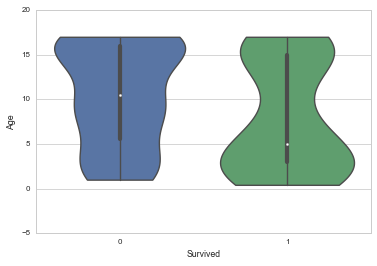

In [16]:
visualize_surv_violin(df_with_ages[df_with_ages['Age'] < 18])

For children the distribution has most differences between survivors an non survivors. There is a pattern to be less likely to survive the older the child get. But that's expected as most of the non-survivers were 20-30 years old.

In [17]:
def ttest(series_x, series_y, t_critical, alpha):
    print u"\u03B1 = {}".format(alpha)
    
    ## Get the means
    xbar = series_x.mean()
    ybar = series_y.mean()

    # Calculate Sum of Squares for samples
    ss_x = np.sum((series_x - xbar) ** 2)
    ss_y = np.sum((series_y - ybar) ** 2)

    # Degree of Freedom
    dof = series_x.count() + series_y.count() - 2
    print "Degree of freedom: {}".format(dof)
    # Pooled Variance
    pooled_var = (ss_x + ss_y)/dof

    # Standared Error
    st_err = math.sqrt(pooled_var/series_x.count() + pooled_var/series_y.count())

    # t-statistic
    t_statistic = (xbar - ybar)/st_err
    print "t-statistic: {}".format(round(t_statistic,2))
    
    # t-critical 
    print "t-critical: {}".format(t_critical)

    #p-value
    p = stats.t.sf(np.abs(t_statistic), dof)*2
    
    print "p-value: {}".format(p)
    
    print "The result is{} statistically significant".format("not" if p > alpha else "")
    # Accept/Reject the null
    print "We {} the null hypothesis.".format("accept" if abs(t_statistic) <= t_critical else "reject")

    # Margin of Error
    margin_of_error = t_critical * st_err
    
    # Confidence interval
    CI_left = xbar - ybar - margin_of_error
    CI_right = xbar - ybar + margin_of_error
    print "CI({}%) = ({}, {})".format((1-alpha)*100, round(CI_left,2), round(CI_right, 2))

Now we're gonna make a quick test on the chance of survival between man and women
#### *H0: There difference in the chance of survival for men and women*
#### * H1: The chance of survival between men and women is different*

In [18]:
ttest(get_adults_by_gender('female')['Survived'], get_adults_by_gender('male')['Survived'], 2.581, 0.01)

α = 0.01
Degree of freedom: 599
t-statistic: 17.48
t-critical: 2.581
p-value: 1.39947704741e-55
The result is statistically significant
We reject the null hypothesis.
CI(99.0%) = (0.51, 0.68)


In [19]:
#### *We are 99% confident women have between 50% and 68% higher chance than man for survival 

### Survival rate by socio-economic status (Pclass)

([<matplotlib.patches.Wedge at 0x11a4d3b50>,
  <matplotlib.text.Text at 0x11a66f110>])

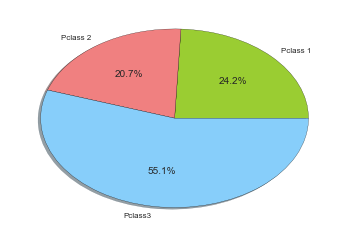

In [20]:
# Data to plot
labels = 'Pclass 1', 'Pclass 2', 'Pclass3'
sizes = [215, 130, 245, 210]
colors = ['yellowgreen', 'lightcoral', 'lightskyblue']
 
# Plot
plt.pie(passengers_df.groupby('Pclass')['PassengerId'].count().values, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True)

We can see most of the people are with low socio-economic status.

In [21]:
# Group passengers by Pclass and calculate the mean of survivability for each Pclass
class_surv_data = pd.DataFrame(passengers_df.groupby('Pclass')['Survived'].mean()).T
class_surv_data

Pclass,1,2,3
Survived,0.62963,0.472826,0.242363


It's obvious the survival rate increases with upper class

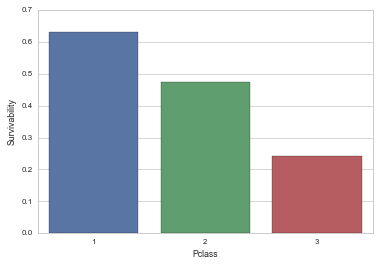

In [22]:
# Visualize survivability for each Pclass
visualize_surv_barplot(class_surv_data)

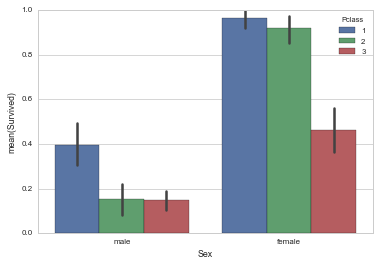

In [23]:
# Visualize survivability by age and class
sns.barplot(x="Sex", y="Survived", hue="Pclass", data=df_with_ages)

The data is a lot different when split by gender. While men have almost twice survivability rate for Pclass 1 compared to 2 and 3, almost all females from class 1 and 2 survived while in Pclass 3 there is a significant drop.

As mentioned earlier the drop in children survivability might happen in Pclass 3

In [24]:
df_with_ages[df_with_ages['Age'] < 18].groupby('Pclass')[['Survived']].describe().unstack()\
    .loc[:,(slice(None),['count','mean']),]

Survived          
          count      mean
Pclass                   
1            12  0.916667
2            23  0.913043
3            78  0.371795

And indeed, most of the children were in Pclass 3 where their mean is only 0.35 and this causes the average for all to be low.

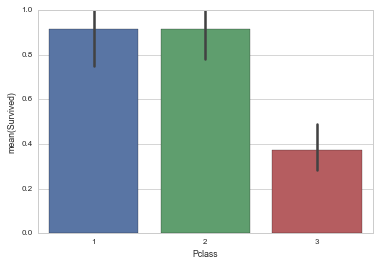

In [25]:
# Display children survival distribution by Pclass
sns.barplot(x="Pclass", y="Survived", data=df_with_ages[df_with_ages['Age'] < 18])

### Here we'll test if the chance of surviving between those who have relatives and those who don't is statistically significant at α = 0.01

In [26]:
print u'H\u2080: \u039Chr = \u039cnhr          H\u2081: \u039Chr \u2260 \u039cnhr          \u03B1 = .01'

H₀: Μhr = Μnhr          H₁: Μhr ≠ Μnhr          α = .01


In [27]:
# separate those having relatives (hr) from those who don't (nhr)
having_relatives = passengers_df[(passengers_df['SibSp'] > 0) | (passengers_df['Parch'] > 0)]['Survived']
not_having_relatives = passengers_df[(passengers_df['SibSp'] == 0) & (passengers_df['Parch'] == 0)]['Survived']

print having_relatives.describe()
print not_having_relatives.describe()

count    354.000000
mean       0.505650
std        0.500676
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64
count    537.000000
mean       0.303538
std        0.460214
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64


In [28]:
ttest(having_relatives, not_having_relatives, 2.581, 0.01)

α = 0.01
Degree of freedom: 889
t-statistic: 6.19
t-critical: 2.581
p-value: 9.00949017933e-10
The result is statistically significant
We reject the null hypothesis.
CI(99.0%) = (0.12, 0.29)


** The two-tailed P value is less than 0.0001 **  
** By conventional criteria, this difference is considered to be extremely statistically significant. **  
** *Based on the result Μhr ≠ Μnhr and we can reject the null hypotheses. * **

** *We are 99% sure that people who have relatives on criuses have between 12% and 29% higher chance of surviving in case of a shipwreck* **

In [29]:
# Another way of computing the t-statistic and p-value would be this one 
# but I did the above because of the confidence intervals
t, p = stats.ttest_ind(having_relatives, not_having_relatives)
"t-statistic: {}, p-value: {}".format(t,p)

't-statistic: 6.19303248808, p-value: 9.00949017933e-10'

### Examine distribution of people on embarkment

In [30]:
# Get the means
embarkation_mean = passengers_df.groupby('Embarked').mean()[['Survived', 'Pclass', 'Fare','Age']]
embarkation_mean

,Survived,Pclass,Fare,Age
Embarked,,,,
C,0.553571,1.886905,59.954144,30.814769
Q,0.389610,2.909091,13.276030,28.089286
S,0.336957,2.350932,27.079812,29.445397


The only interesting thing we can see from the above table is that most of the people that have been Embarked in Cherbourg were rich. But from the table below we can see they were not as many as Southampton

In [31]:
# Function for displaying the below graphics preventing repetition of the plot settings
def display_embarked_by_pclass(df):
    sns.countplot(x="Embarked", hue="Pclass", data=df, order=['S', 'C', 'Q']);

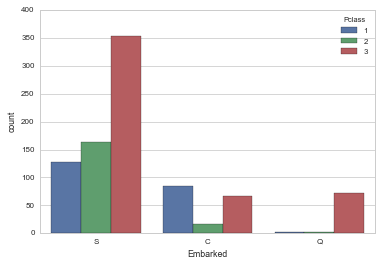

In [32]:
# Display distribution by Pclass
display_embarked_by_pclass(passengers_df)

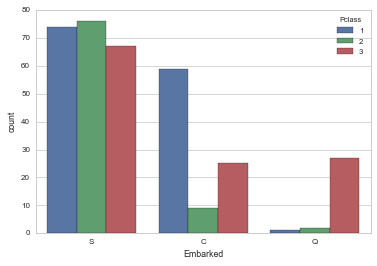

In [33]:
# Display survivors location
display_embarked_by_pclass(passengers_df[passengers_df['Survived'] == 1])

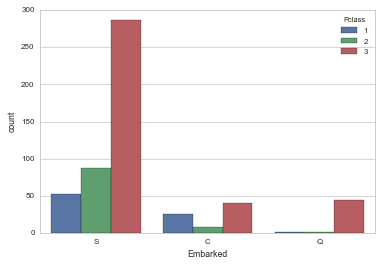

In [34]:
# Display non-survivors location
display_embarked_by_pclass(passengers_df[passengers_df['Survived'] != 1])

We can see from the above graphics that most bodies Embarked in Southampton

### Conclusions

##### From the results we can conclude that you best bet of surviving is to be a middle age woman with higher or middle socio-economic status not travelling alone. And the lowest chance is youn man from lower class travelling alone.

Let's test the above scenario

w = woman, 30 - 60, Pclass 1 or 2, with relative(s)<br />
m = man 18-30, Pclass 3, alone<br />
H₀: Μw = Μm<br />H₁: Μw ≠ Μm<br />α = .01<br />

In [35]:
def w_cond():
    return df_with_ages[
        (df_with_ages['Sex'] == 'female') &
        (df_with_ages['Age'] >= 30) & 
        (df_with_ages['Age'] <= 60) & 
        (df_with_ages['Pclass'] < 3) & 
        ((df_with_ages['SibSp'] > 0) | (df_with_ages['Parch'] > 0))
    ];
def m_cond():
    return df_with_ages[
        (df_with_ages['Sex'] == 'male') &
        (df_with_ages['Age'] >= 18) & 
        (df_with_ages['Age'] <= 30) & 
        (df_with_ages['Pclass'] == 3) & 
        (df_with_ages['SibSp'] == 0) &
        (df_with_ages['Parch'] == 0)
    ];
w_sample = w_cond()
m_sample = m_cond()

print "Samples w:{}, m:{}".format(w_sample['PassengerId'].count(), m_sample['PassengerId'].count())
ttest(w_sample['Survived'], m_sample['Survived'], 2.626, 0.01)

Samples w:47, m:110
α = 0.01
Degree of freedom: 155
t-statistic: 15.55
t-critical: 2.626
p-value: 1.84451507098e-33
The result is statistically significant
We reject the null hypothesis.
CI(99.0%) = (0.69, 0.97)


#### *Overall we are 99% confident that the w group has between 69% and 97% higher chance of surviving than m group*

This study was concentrated on calculating the survivability from shipwrecks and its realtion with different factors like age, gender and social status. However there were some limitations. For example about 20% of the age data was missing. While the size of the data was good enough there are a lot of lurking variables when talking about shipwrecks like weather, timeof the day, location. The year of when it happened also affects it since cruisers of this type nowadays are supposed to be a lot better and thanks to the communications can be reacted a lot faster. Another issue is that the data is from a single shipwreck. Every shipwreck has an unique story and having multiple samples from different events would make the research a lot more conclusive. But if we had those records we could go into other directions like comparing decades, locations, etc. - all those lurking variables.
In regards with the data available it would have been great if we had the relatives connections. Then we could have sampled the families and tackle on other topics like family survivability. Another interesting thing if we had the cabin data would be to build heat map for the fare price on the ship.

Apart from those limitations the data was good enough to draw several hypothesis which might be further established with research on other shipwrecks:
Women are 51 to 68% more likely to survive than men.
You'll probably have between 12 and 29 higher chance if not travelling alone.
Being from a higher class would also increase your chances (0.63 vs. 0.24 average survivability for Pclass 1 vs. Pclass 3) 

If you're middle aged high class woman go ahead, if you're young lower class man - think again!

P.S. Almost 5% of people were named William :)

Sources:
  1. [Titanic passengers' data and description](https://www.kaggle.com/c/titanic/data)
  2. [T table](https://s3.amazonaws.com/udacity-hosted-downloads/t-table.jpg)